**Proyecto de Grado**

**Título:** Modelo para la detección de noticias falsas en formato texto en la red social Twitter, aplicado al contexto político colombiano de las elecciones presidenciales de 2022.

----Version Final----

**Integrantes:**
* Jesus Eduardo Flores Q.
* Juan Gabriel Montaño M.

#**Instalaciones**

In [1]:
!pip install tweepy
!pip3 install tqdm
!pip install spacy
!pip install matplotlib
!pip install wordcloud
!pip install unidecode
!pip install scikit-plot
!pip install bayesian-optimization
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
!pip install stop-words

#Instalacion de librerias para extracción de URLs y Webscrapping
!pip install beautifulsoup4
!pip install requests
!pip install URLExtract

# paquetes necesarios para trabajar con BERT
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=aac93f361d0d6d928ed9b412dbf3e7ece756

#**Librerias**

In [2]:
import io
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import string
import tweepy
from tqdm.notebook import tqdm as tqdm_notebook
from dateutil import tz
from datetime import datetime 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import requests
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from google.colab import (
    drive,
    files
)
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from stop_words import get_stop_words
import pickle
import xgboost as xgb
from sklearn.linear_model import PassiveAggressiveClassifier
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

#### 
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # creacion AdamW optimizer

## libreria para descargar un .zip desde una url de descarga
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import os

#Libreria display tabla
from IPython.display import display

#Librerias extracción URLs y webscrapping
import requests
from bs4 import BeautifulSoup
from urlextract import URLExtract
from urllib.parse import urlparse


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#**Funciones**

In [3]:
#Seed para hacer reproducibles los resultados
np.random.seed(42)
rng = np.random.RandomState(1)

In [4]:
# al llamar la función y pasarle una URL, descarga el arhcivo que debe estar en formato .zip y lo descomprime en la ruta content de colab
def download_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

In [5]:
#Funcion que convierte el formato de la fecha del tweet en hora GMT -5 Colombia
def convert_date(str_date):
  str_format_date = '%Y-%m-%d %H:%M:%S' 
  from_zone = tz.gettz('UTC')
  to_zone = tz.gettz('America/Bogota')
  date_convert = datetime.strptime(str(str_date), str_format_date)
  date_convert = date_convert.replace(tzinfo=from_zone)
  date_convert = date_convert.astimezone(to_zone)
  date_convert = datetime.strftime(date_convert,'%d/%m/%Y %H:%M:%S')
  return date_convert

In [6]:
#Funcion para obtener los tweets de un usuario especifico de twitter - Se quitan los ReeTweets
def get_tweets(api,username,items,rts):
  tweets={}
  for tweet in tqdm_notebook(tweepy.Cursor(api.user_timeline, screen_name = username, tweet_mode='extended',include_rts=rts).items(items)):
      tweets[tweet.id]= {
          'full_text': tweet.full_text,
          'created_at': convert_date(tweet.created_at),
          'author_name': tweet.user.name,
          'author_handler': str(tweet.user.screen_name),
          'user_description': tweet.user.description,
          'user_location': tweet.user.location,
          'user_followers_count': tweet.user.followers_count,
          'user_created_at': convert_date(tweet.user.created_at),
          'user_following_count': tweet.user.friends_count,
          'user_verified': tweet.user.verified,
          'lang': tweet.lang,
          'tweet_hashtags': tweet.entities['hashtags'],
          'mention_names': ["@" + d['screen_name'] for d in tweet.entities['user_mentions'] if 'screen_name' in d],
          'mention_ids': [d['id'] for d in tweet.entities['user_mentions'] if 'id' in d],
          'n_retweets': tweet.retweet_count,
          'n_favorites': tweet.favorite_count,
          'is_retweet': hasattr(tweet, 'retweeted_status')
      }
  df_tweets = pd.DataFrame.from_dict(tweets, orient='index')
  df_tweets['id'] = df_tweets.index
  return df_tweets

In [7]:
 # Remover saltos de linea
def remove_newlines_tabs(text):
  formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
  return formatted_text

In [8]:
# Remover espacios en blanco
def remove_whitespace(text):
    pattern = re.compile(r'\s+') 
    without_whitespace = re.sub(pattern, ' ', text)
    text = without_whitespace.replace(')', ') ')
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").lstrip()
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").rstrip()
    text=text.replace("   ", "")
    return text    

In [9]:
def accented_characters_removal(text):
  # Remover tildes
    text = unidecode.unidecode(text)
    return text

In [10]:
def remove_special_characters(text):
    # Remover caracteres especiales
    return text.translate(str.maketrans('','',string.punctuation))

In [11]:
def lower_text(text):
    # Convertir mayusculas a minusculas
    text = text.lower()
    return text

In [12]:
stoplist = list(get_stop_words('spanish'))  
nltk_words = list(stopwords.words('spanish')) 
stoplist.extend(nltk_words)
def remove_stopwords(text):
    # Remover stop words
    nostopwords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convertir lista en tipo String
    words_string = ' '.join(nostopwords)   
    return words_string

In [13]:
# función para realizar la lematización del texto con la librería Spacy
nlp = spacy.load('en_core_web_sm')
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [14]:
def remove_links(text): 
    # Remover urls 
    text=re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    text=re.sub(r'https?://\S+|www\.\S+','',text)
    text=re.sub(r'opr-littps://S+','',text)
    return text

In [15]:
def remove_numbers(text):
    # Quitar la palabra NUMBER y number del corpus del contexto mexicano
    formatted_text=''.join((x for x in text if not x.isdigit()))
    formatted_text= re.sub(r"NUMBER", ' ', formatted_text)
    formatted_text= re.sub(r"number", ' ', formatted_text)
    return formatted_text

In [16]:
# Función que realiza todo el preprocesamiento del texto
def text_preprocessing(text, accented_chars=True, newlines_tabs=True, extra_whitespace=True,lowercase=True,characters_specials=True,stop_words=True,lemmatization = True,links=True,numbers_remove=True):     

    if newlines_tabs == True:  # Remover saltos de linea
        data = remove_newlines_tabs(text) 
   
    if links == True: #remove links
        data = remove_links(data)
        
    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)
    
    if lowercase == True: # Convertir mayusculas a minusculas
        data = lower_text(data)
    
    if characters_specials == True: # Remover signos de puntuación
        data = remove_special_characters(data)

    if numbers_remove == True: # Remover números
        data = remove_numbers(data)

    if accented_chars == True: # Remover tildes
        data = accented_characters_removal(data) 

    if stop_words == True: # Remover stopwords
        data = remove_stopwords(data) 

    if lemmatization == True: # Lematizacion
       data = lemmatizer(data)

    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)

    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)    
       
    return data

In [17]:
# Función para cambiar las categorias de las noticias
def change_categories(campo):
    if campo=='True' or campo=='Noticia Real' or campo=='0':
        return 'Noticia Real'
    else:
        return 'Noticia Falsa'

In [18]:
#Función para exportar los modelos en formato pickle
def create_model_production(name_model,model):
  with open(name_model+'.pkl','wb') as model_pkl:
    pickle.dump(model, model_pkl, protocol=2)

In [19]:
# Función para la busqueda de hiperparametros con RandomSearch
def randomsearchmodels(model,hyperparameters_tuning,features_train_f,labels_train_f,features_test_f,labels_test_f):
  gridsearch = RandomizedSearchCV(model,hyperparameters_tuning,n_iter=10,scoring='accuracy',cv=3,verbose=1,random_state=8)
  gridsearch.fit(features_train_f,labels_train_f)
  predictions = gridsearch.predict(features_test_f)
  accuracy_model=accuracy_score(predictions, labels_test_f)
  return gridsearch,predictions,accuracy_model

In [20]:
# Función para realizar la representación del texto por medio de TF-IDF
def tifdf_features (X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features):
  tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
  features_train = tfidf.fit_transform(X_train)
  features_test = tfidf.transform(X_test)
  labels_train = y_train
  labels_test = y_test
  return features_train,features_test,labels_train,labels_test,tfidf

In [21]:
# función para realizar la detección de noticias falsa con el corpus del contexto político colombiano.
def detection_fake_news_cp(news, model):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf_cp.transform(input_data)
    prediction = model.predict(vectorized_input_data)
    prediction_proba = model.predict_proba(vectorized_input_data)
    if prediction==0:
      return "La noticia es real con una probabilidad de: ",prediction_proba[0][0]
    else:
       return "La noticia es falsa con una probabilidad de: ",prediction_proba[0][1]

In [22]:
# función para realizar la detección de noticias falsa con el corpus combinado
def detection_fake_news_(news, model):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf.transform(input_data)
    prediction = model.predict(vectorized_input_data)
    prediction_proba = model.predict_proba(vectorized_input_data)
    if prediction==0:
      return True
    else:
      return False

In [23]:
# función para realizar webscrapping de las páginas web, la función recupera los parrafos que cumplan la condición de 
#tener una longitud de caracteres entre 300 y 400
def webscrapping (url):
  news=""
  req=requests.get(url)
  statusCode = req.status_code
  if statusCode == 200:
    html=BeautifulSoup(req.text,"html.parser")
    for i in html.find_all("p"):
      if(len(i.get_text())>100 and len(i.get_text())<400):
        news=news+i.get_text()
    return news

In [24]:
# Extrae la URL del Tweet
def geturlfromtweet(tweet):
  extractor=URLExtract()
  url=extractor.find_urls(tweet)
  print(url)
  if len(url)!=0:
    return url[0]
  return "False"

In [25]:
# función que extrae un Tweet de la página web y realiza la clasificación.
def classification_news_twitter(accountname_twitter,count_tweets, model):
  df_news_classified=[]
  df_temp_tweets=get_tweets(api,accountname_twitter,count_tweets,False)
  df_temp_tweets=df_temp_tweets[["full_text"]].values.tolist()
  for tweet in df_temp_tweets:
    df_news_classified.append(detection_fake_news_cp(webscrapping_text(tweet[0]),model))
  return df_news_classified

In [26]:
def imprimirPrediccionBERT(tweet, reloaded_results):
  result_for_printing = \
    [f'input: {tweet[i]:<30} : score: {reloaded_results[i][0]:.6f}' for i in range(len(tweet))]
  print(*result_for_printing, sep='\n')
  print()

In [27]:
# función que extrae un Tweet de la página web y realiza la clasificación.
def recoleccionTweets(accountname_twitter,count_tweets):
  listaGrupoTweets=[]
  df_temp_tweets=get_tweets(api,accountname_twitter,count_tweets,False)
  df_temp_tweets=df_temp_tweets[["full_text"]].values.tolist()
  for tweet in df_temp_tweets:
      listaGrupoTweets.append(webscrapping_text(tweet[0]))
  return listaGrupoTweets

In [28]:
# función que extrae un Tweet de la página web y realiza la clasificación.
def classification_news_twitter_BERT(accountname_twitter,count_tweets):
  listaTweets=recoleccionTweets(accountname_twitter,count_tweets)
  df_temp_tweets=get_tweets(api,accountname_twitter,count_tweets,False)
  df_temp_tweets=df_temp_tweets[["full_text"]].values.tolist()
  reloaded_results = tf.sigmoid(reloaded_model(tf.constant(listaTweets)))
  imprimirPrediccionBERT(listaTweets, reloaded_results)

In [29]:
# Función que extrae el texto del Tweet
def webscrapping_text(tweet):
  url=geturlfromtweet(tweet)
  if(url!="False"):
    news_text=webscrapping(url)
    return news_text
  else:
      return tweet

In [30]:
#@title Seleccione el modelo de BERT para el fine-tune
# carga del modelo y el modulo de preprocesamiento
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'distilbert_multi_cased_L-6_H-768_A-12':
      'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'distilbert_multi_cased_L-6_H-768_A-12':
      'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


#**Twitter**

Credenciales Consumo API

In [31]:
# API Keys para autenticacion
api_key = "UcZ9gR5yMV4MlKTFaSwhC1aNX" 
api_secret = "R5BjKcmHan6MGaX98UMhytQfLiZI7TLl9AATGtixJLwmAU2DFR"
access_token = "1452452402070794241-rKitK0leSslMs9XoXEDBTxOwplOGGU"
access_token_secret = "lBAxKokr4Hkg3DxvaUMTWkAqU0E9O5KfZCmJoPulnfSRn"

In [32]:
# Autorización para consumo API
auth = tweepy.OAuthHandler(api_key, api_secret) 
# Acceso al API
auth.set_access_token(access_token, access_token_secret) 
# Instancia para llamar a la API 
api = tweepy.API(auth, wait_on_rate_limit=True) 

In [33]:
#Obtener Tweets de cuenta
df_tweets=get_tweets(api,"@revistasemana",10,False)

0it [00:00, ?it/s]

In [34]:
# Se define un dataframe temporal para extraer las columnas más representativas de los Tweets
df_tweets_temp=df_tweets[["full_text","created_at","author_name","user_followers_count"]]
df_tweets_temp.columns=["Tweet","Fecha Creacion","Cuenta","Cantidad Seguidores"]
df_tweets_temp.set_index("Fecha Creacion",inplace=True)

In [35]:
display(df_tweets_temp)

Tweet  \
Fecha Creacion                                                           
28/05/2022 11:30:20  Teresa Berganza y otros grandes cantantes de l...   
28/05/2022 11:28:05  Liverpool vs. Real Madrid: Canal y hora para v...   
28/05/2022 11:24:44  “Rechazamos cualquier tipo de explotación sexu...   
28/05/2022 11:20:35  ¡Viva la reina! Karol G cautivó con su música ...   
28/05/2022 11:12:07  A Cuadrado “se le escapó” el destino de James ...   
28/05/2022 11:11:05  La viruela del mono invade a Europa: ¿hay que ...   
28/05/2022 11:05:26  SEMANA conoció cómo los extraditables hacen ca...   
28/05/2022 11:05:12  #Ampliación | Giro de Italia 2022 | Jai Hindle...   
28/05/2022 11:00:56  El capital en la semana de la moda de Bogotá h...   
28/05/2022 10:57:38  “Qué diablos hace, dio papaya”: Gustavo Petro,...   

                             Cuenta  Cantidad Seguidores  
Fecha Creacion                                            
28/05/2022 11:30:20  Revista Semana              4925922  
28/05/2022 11:28:05  Revista Semana              4925922  
28/05/2022 11:24:44  Revista Semana              4925922  
28/05/2022 11:20:35  Revista Semana              4925922  
28/05/2022 11:12:07  Revista Semana              4925922  
28/05/2022 11:11:05  Revista Semana              4925922  
28/05/2022 11:05:26  Revista Semana              4925922  
28/05/2022 11:05:12  Revista Semana              4925922  
28/05/2022 11:00:56  Revista Semana              4925922  
28/05/2022 10:57:38  Revista Semana              4925922

#**Cargar Corpus**

In [36]:
url_archivos='https://docs.google.com/uc?export=download&id=10c_3sI5gDKl5GCyo1Aea34DhRWdTUya6'
download_unzip(url_archivos)

In [37]:
# Lectura de los corpus
%%time
df=pd.read_excel("files/Corpus_Noticias_Falsas.xlsx") # Corpus del Contexto político colombiano
df2=pd.read_excel("files/train.xlsx") # Corpus del contexto mejicano
df3=pd.read_csv("files/fakes2000.csv", skipinitialspace=True, skip_blank_lines=True, encoding='utf-8') # Corpus otros contextos
df_stopwords=pd.read_csv("files/spanish.txt") # Archivo que complementa las stopwords para el lenguaje español

CPU times: user 845 ms, sys: 44.8 ms, total: 890 ms
Wall time: 1.37 s


In [38]:
# filtro por categoria y texto
df=df[['Categoria','Texto']] # Corpus del contexto político colombiano
df

Categoria                                              Texto
0    Noticia Real  El presidente Iván Duque condenó fuertemente e...
1    Noticia Real  Gustavo Petro se reunirá con Pedro Sánchez, pr...
2    Noticia Real  Marta Lucía Ramírez se queja por servicio en e...
3    Noticia Real  Elecciones de 2022 requieren mayor cuidado, po...
4    Noticia Real  ANTE LA expansión de la variante ómicron en el...
..            ...                                                ...
629  Noticia Real  Consejo Nacional Electoral pide auditoría de s...
630  Noticia Real  Registrador Nacional anuncia cambios en formul...
631  Noticia Real  Gobernación del Valle acompaña a la Registradu...
632  Noticia Real  Autoridades ratifican medidas de seguridad par...
633  Noticia Real  ¿Nueva alianza? Ingrid Betancourt estaría disp...

[634 rows x 2 columns]

In [39]:
#stoplist.clear() : funcion para borra el contenido de la lista
stoplist.extend(df_stopwords['stopwords'].tolist())
len(stoplist)

1229

In [40]:
# eliminar las tildes de los stopword para la limpieza.
list_stop_words = []
for n in stoplist:
  list_stop_words.append(unidecode.unidecode(n))
stoplist=list_stop_words

In [41]:
# Inspeccionar las categorias del corpus del contexto político colombiano
df.value_counts(df['Categoria'])

Categoria
Noticia Falsa    317
Noticia Real     317
dtype: int64

In [42]:
## seleccionar las dos columnas del corpus del contexto mejicano (676 noticias)
df2=df2[['Category','Text']] # Corpus Posadas-Duran
df2

Category                                               Text
0       Fake  RAE INCLUIRÁ LA PALABRA "LADY" EN EL DICCIONAR...
1       Fake  La palabra "haiga", aceptada por la RAE La Rea...
2       Fake  YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...
3       True  UNAM capacitará a maestros para aprobar prueba...
4       Fake  Alerta: pretenden aprobar libros escolares con...
..       ...                                                ...
671     Fake  Madonna será la nueva imagen del Chocolate Abu...
672     True  Filtran material íntimo de Zelina Vega, luchad...
673     Fake  CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674     Fake  TV Azteca anuncia que cambiará su nombre por u...
675     Fake  MUERTE DE PETER EL ANGUILA POR SOBREDOSIS\nPet...

[676 rows x 2 columns]

In [43]:
# se renombran las columas para realizar la union de los dos corpus
df2=df2.rename(columns={'Category':'Categoria', 'Text':'Texto'})

In [44]:
# Inspeccionar las categorias
df2.value_counts('Categoria')

Categoria
Fake    338
True    338
dtype: int64

In [45]:
## corpus de 2000 noticias (Fake2000) de otros contextos del lenguaje español.
df3

class                                               Text
0      True   Algunas de las voces extremistas más conocida...
1      True   Después de casi dos años y medio de luchas po...
2      True  Dos periodistas birmanos de la agencia Reuters...
3      True  El Cuerpo Nacional de Policía ha detenido a cu...
4      True  El desfile de la firma en Roma se convierte en...
...     ...                                                ...
1995   True   El Consejo de Gobierno ha dado su visto bueno...
1996   True   Investigadores valencianos han desarrollado u...
1997   True   Los arrestados actuaban en coches y en establ...
1998   True   El Rey ha encargado este miércoles a Pedro Sá...
1999   True   Las pruebas realizadas en el Centro Nacional ...

[2000 rows x 2 columns]

In [46]:
# visualizar la tabla de frecuencias de las categorias. Las clases se encuentran balanceadas.
df3['class'].value_counts()

True     1000
False    1000
Name: class, dtype: int64

In [47]:
# renombramos las columnas para que queden todas con igual nombre, de esta manera se realiza correctamente la concatenación.
df3=df3.rename(columns={'class':'Categoria', 'Text':'Texto'})

In [48]:
#copia de datafrme del contexto poliítico colombiano
df_base_cp=df

In [49]:
#Union de los dos tres corpus
df_base=pd.concat([df,df2,df3], axis=0, ignore_index=False)

In [50]:
# visualización de como queda el corpus de 3310 noticias.
df_base

Categoria                                              Texto
0     Noticia Real  El presidente Iván Duque condenó fuertemente e...
1     Noticia Real  Gustavo Petro se reunirá con Pedro Sánchez, pr...
2     Noticia Real  Marta Lucía Ramírez se queja por servicio en e...
3     Noticia Real  Elecciones de 2022 requieren mayor cuidado, po...
4     Noticia Real  ANTE LA expansión de la variante ómicron en el...
...            ...                                                ...
1995          True   El Consejo de Gobierno ha dado su visto bueno...
1996          True   Investigadores valencianos han desarrollado u...
1997          True   Los arrestados actuaban en coches y en establ...
1998          True   El Rey ha encargado este miércoles a Pedro Sá...
1999          True   Las pruebas realizadas en el Centro Nacional ...

[3310 rows x 2 columns]

In [51]:
# se observa que las clases True estan siendo leidas de forma diferente
df_base.Categoria.value_counts()

True             1000
False            1000
Fake              338
True              338
Noticia Real      317
Noticia Falsa     317
Name: Categoria, dtype: int64

In [52]:
# Se exportan los datos a CSV
df_base.to_csv('salida.csv')

In [53]:
# se realiza la lectura del CSV.
df_base=pd.read_csv('salida.csv')

In [54]:
# Se observa como la categoria True ya fue leida como una sola. paso siguiente es Unificar las categorias.
df_base.Categoria.value_counts()

True             1338
False            1000
Fake              338
Noticia Real      317
Noticia Falsa     317
Name: Categoria, dtype: int64

In [55]:
# cambiar el nombre de la categoria para dejar el corpus uniforme: Fake=Noticia Falsa, True=Noticia Real
df_base["Categoria"]=df_base["Categoria"].apply(change_categories)
df_base

Unnamed: 0     Categoria  \
0              0  Noticia Real   
1              1  Noticia Real   
2              2  Noticia Real   
3              3  Noticia Real   
4              4  Noticia Real   
...          ...           ...   
3305        1995  Noticia Real   
3306        1996  Noticia Real   
3307        1997  Noticia Real   
3308        1998  Noticia Real   
3309        1999  Noticia Real   

                                                  Texto  
0     El presidente Iván Duque condenó fuertemente e...  
1     Gustavo Petro se reunirá con Pedro Sánchez, pr...  
2     Marta Lucía Ramírez se queja por servicio en e...  
3     Elecciones de 2022 requieren mayor cuidado, po...  
4     ANTE LA expansión de la variante ómicron en el...  
...                                                 ...  
3305   El Consejo de Gobierno ha dado su visto bueno...  
3306   Investigadores valencianos han desarrollado u...  
3307   Los arrestados actuaban en coches y en establ...  
3308   El Rey ha encargado este miércoles a Pedro Sá...  
3309   Las pruebas realizadas en el Centro Nacional ...  

[3310 rows x 3 columns]

In [56]:
# Conteo del numero de noticias falsas y verdaderas. Se observa que quedan  balanceadas.
df_base.Categoria.value_counts()

Noticia Real     1655
Noticia Falsa    1655
Name: Categoria, dtype: int64

In [57]:
# Copia del corpus combinado. 
df_merge=df_base

#**Preprocesamiento**

Tareas de pre-procesamiento a realizar:
* Convertir Mayusculas a minusculas
* Remover links
* Remover números
* Remover signos de puntuación
* Remover tildes
* Remover comillas
* Remover retornos y lineas nuevas
* Remover StopWords
* Lematización

### **Preprocesamiento Corpus del contexto politico colombiano**

In [58]:
#Preprocesamiento Corpus 634 noticias
List_News = df_base_cp['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_base_cp['Processed_Text'] = Complete_Content

100%|██████████| 634/634 [00:19<00:00, 33.23it/s]


### **Preprocesamiento Corpus Combinado**



In [59]:
#Preprocesamiento Corpus combinado de noticias
List_News = df_merge['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_merge['Processed_Text'] = Complete_Content

100%|██████████| 3310/3310 [01:05<00:00, 50.48it/s] 


In [60]:
df_merge.Texto.iloc[1093]

'SIN ESCAPATORIA: INTERPOL presenta las pruebas de que Carlos Salinas si mató a COLOSIO\nLuis Donaldo Colosio Murrieta recibió un segundo disparo en la camioneta a bordo de la cual fue trasladado al hospital después de haber sido herido en la cabeza en Lomas Taurinas, Tijuana. Esto lo establece una videograbación aportada por la Universidad de Guadalajara.\nLa grabación es prueba indiscutible de que Luis D. Colosio fue víctima de un complot en el que estarían involucrados miembros del Estado Mayor Presidencial que tenían a su cargo la seguridad de Colosio, encabezados por el general brigadier Domiro Roberto García Reyes. La grabación fue desvelada por el noticiario Esferas, que se trasmite en la ciudad de Guadalajara, capital del estado de Jalisco, donde acaba de tener lugar la III cumbre de la Unión Europea y América Latina.\nLa videograbación fue revelada al público al cumplirse *NUMBER* años del crimen del entonces candidato a la Presidencia de la República, y en ella, en cámara len

In [61]:
df_base_cp.Processed_Text.iloc[400]

'atencion noticia hombre identificado alias naruto personas coloco carro bomba academia policia bogota difundir quepagueporloquehizo'

In [62]:
df_merge.Processed_Text.iloc[200]

'ola atracos viene presentando area metropolitana bucaramanga extranjeros medio comunicacion comunica amanda duarte representante extranjeros santander pronuncio respeto gobierno diera subsidio mensual diera vivir mercado vivir colegas robaran mentalidad extranjeros dinero pais dia pais cambie dia llevamos dinero hagamos colombia gobierno colombia incumplio casa vivir beca estudiar colegas toca robar dinero pais'

In [63]:
df_merge.Processed_Text.iloc[1000]

'pedro sanchez anuncia iniciativa conjunta congreso desmantelar politicas pp discurso militante delegado psoe pedro sanchez anunciado aprovechara minoria pp congreso crear iniciativa resto fuerzas politicas permita desarticular leyes aprobadas gobierno rajoy psoe apoya ejecutiva sanchez votos secretario general psoe referido espacio coordinacion parlamentaria fuerzas cambio fuerzas refiere ciudadanos advierte continuan vetos mutuos unico voto util psoe sanchez agradecido patxi lopez susana diaz actitud proceso primarias olvidado alocucion principio discurso referido personas formaron m reunieron anos puerta sol madrid grito representan nicho nacio desarrollo tomado mensaje sanchez aclamacion congreso federal socialista alli dirigido llamada busqueda recuperar votante perdidos psoe anos izquierda gobierno representar anos representan quedado claro sanchez reiterado posteriormente unico competidor unico partido medirse partido popular mira frente competimos partido popular descanso mayor

In [64]:
df_merge.Processed_Text.iloc[1093]

'escapatoria interpol presenta pruebas carlos salinas mato colosio luis donaldo colosio murrieta recibio disparo camioneta bordo trasladado hospital herido cabeza lomas taurinas tijuana establece videograbacion aportada universidad guadalajara grabacion prueba indiscutible luis d colosio victima complot involucrados miembros presidencial cargo seguridad colosio encabezados general brigadier domiro roberto garcia reyes grabacion desvelada noticiario esferas trasmite ciudad guadalajara capital jalisco acaba iii cumbre union europea america latina videograbacion revelada publico cumplirse anos crimen candidato presidencia republica camara lenta aprecia caos traslado victima sitio disparo cabeza camioneta usaba gira intromision escena extranos videograbaciones obtenidas crisis pagina web noticiario jaliciense demuestra colosio herido subido camioneta portezuela derecha trasera conductor noticiero senala observen individuo camioneta tipo corta estatura lente pelon ve portezuela trasera izqu

###**División del Corpus - Noticias Falsas y Verdaderas**

In [65]:
#División Dataframe Corpus combinado
real_news = df_merge[df_merge['Categoria'] == 'Noticia Real']
fake_news = df_merge[df_merge['Categoria'] == 'Noticia Falsa']

In [66]:
#División Dataframe Corpus noticias del contexto político colombiano.
real_news_cp=df_base_cp[df_base_cp['Categoria'] == 'Noticia Real']
fake_news_cp = df_base_cp[df_base_cp['Categoria'] == 'Noticia Falsa']

# **Analitica Descriptiva**

## **Analitica Corpus del contexto politico colombiano**

###**Histograma de categorias**

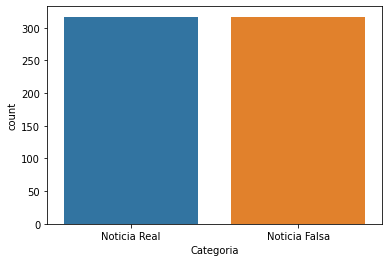

In [67]:
# Distribución de noticias falsas y verdaderas Corpus del contexto politico colombiano
ax = sns.countplot(x="Categoria", data=df_base_cp)

### Word Cloud Real News Corpus del contexto politico colombiano

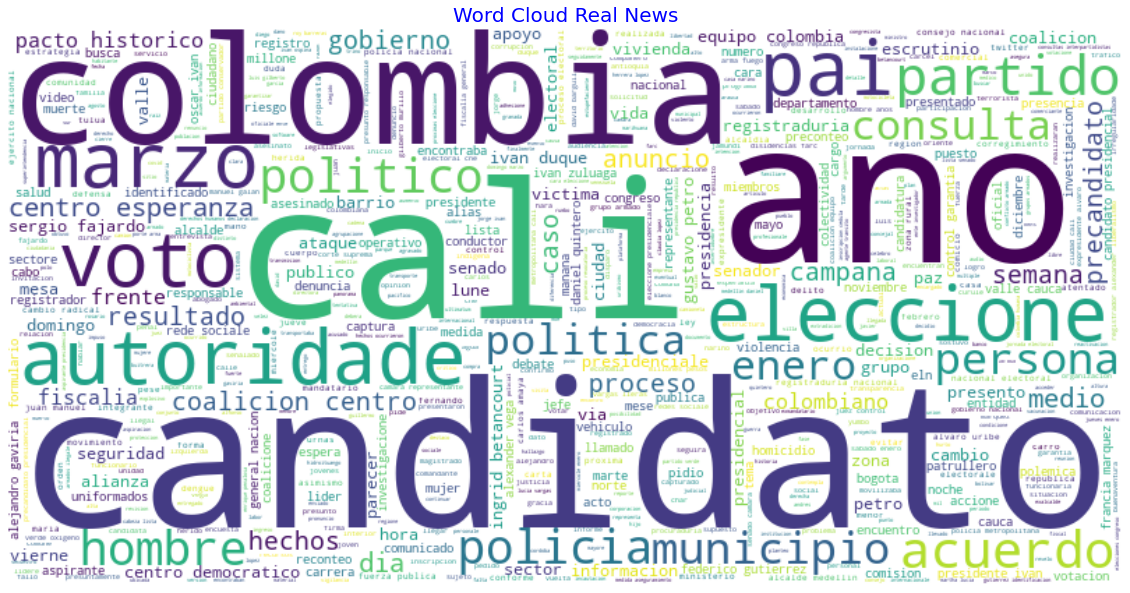

In [68]:
#Wordcloud Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Fake News Corpus del contexto politico colombiano

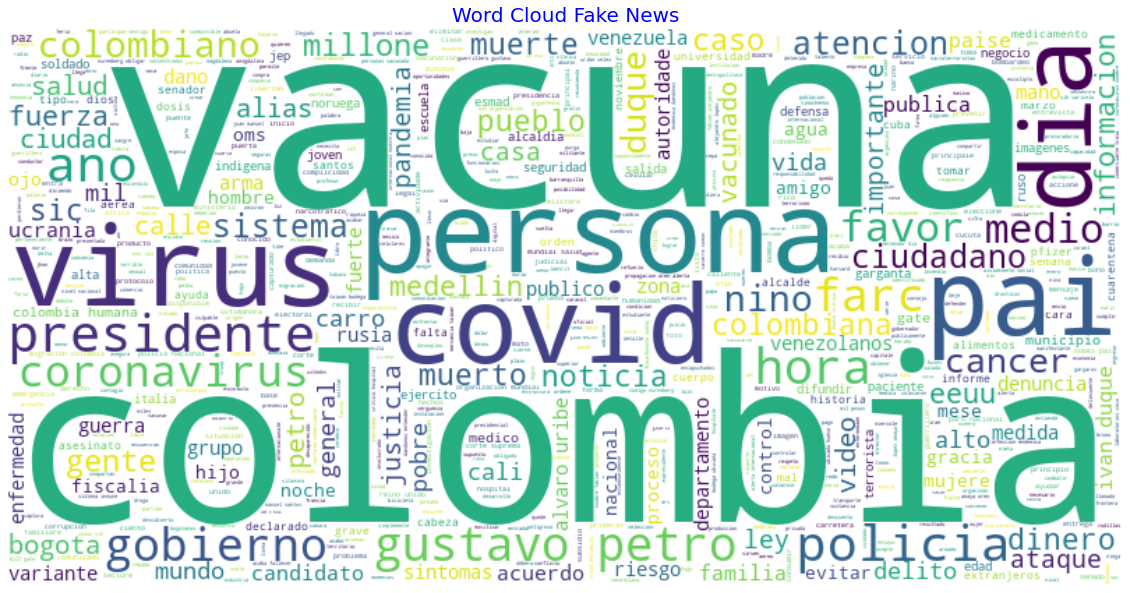

In [69]:
#Wordcloud noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Analitica Corpus Combinado**

###**Histograma de categorias**

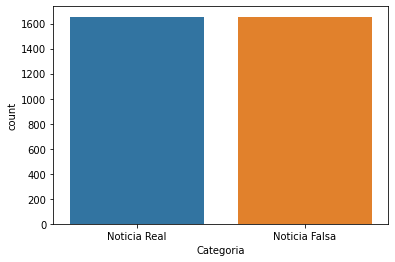

In [70]:
# Distribución de noticias falsas y verdaderas Corpus combinado
ax = sns.countplot(x="Categoria", data=df_merge)

### Word Cloud Fake News Corpus Combinado

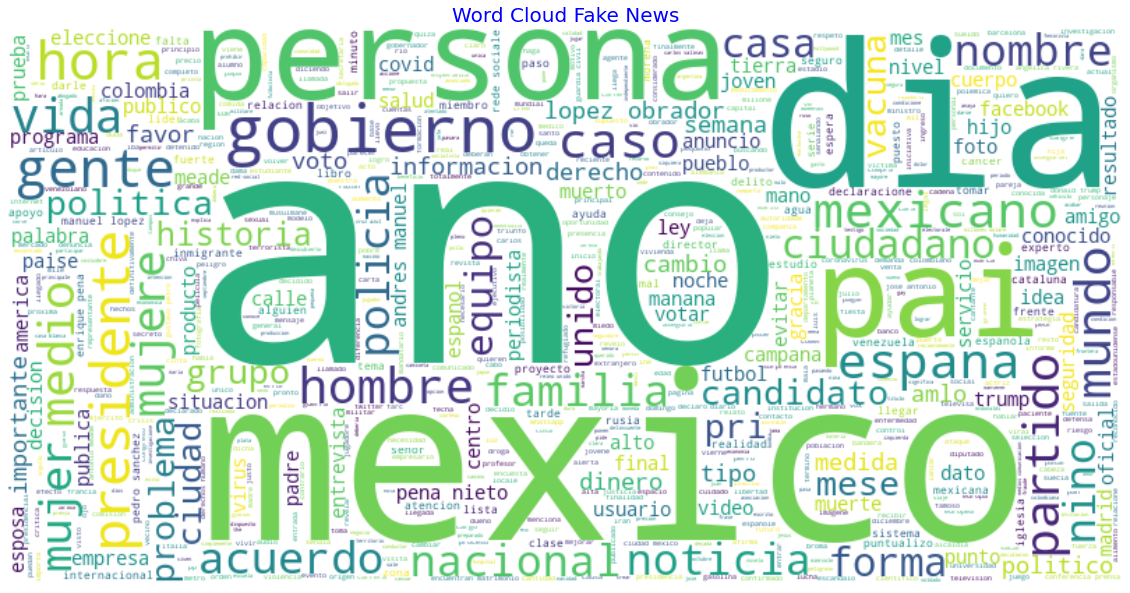

In [71]:
#Wordcloud corpus combinado noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Real News Corpus Combinado

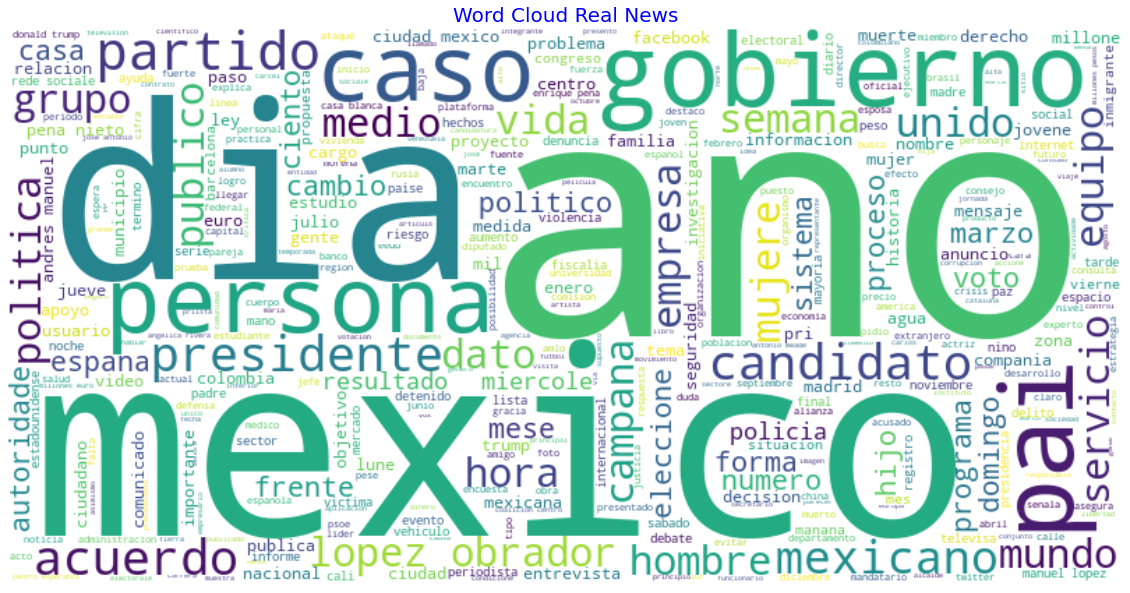

In [72]:
#Wordcloud corpus combinado Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Modelamiento**

## Codificación de etiquetas

In [73]:
#Codificación de etiquetas
category_codes = {
     'Noticia Real': 0,
    'Noticia Falsa': 1
}

In [74]:
# Cambio de categorias corpus combinado
df_merge['Codigo'] = df_merge['Categoria']
df_merge = df_merge.replace({'Codigo':category_codes})

In [75]:
# Cambio de categorias Corpus del contexto politico colombiano
df_base_cp['Codigo'] = df_base_cp['Categoria']
df_base_cp = df_base_cp.replace({'Codigo':category_codes})

## División de datos

Se realiza el particionamiento de los datos en prueba y validación.

In [76]:
#Division de datos - Corpus del contexto politico colombiano
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(df_base_cp['Processed_Text'], 
                                                    df_base_cp['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

In [77]:
#Division de datos - corpus combinado
X_train, X_test, y_train, y_test = train_test_split(df_merge['Processed_Text'], 
                                                    df_merge['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

## **Representación del texto**

La representación del texto se realiza con sklearn mediante la técnica Tfidf parametrizado con unigramas y bigramas del texto

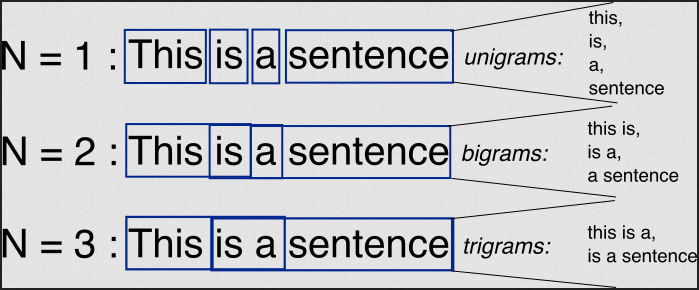

**ngram_range ** tuple (min_n, max_n) default=(1,1): Representa el limite inferior y superior para los n-grams en la extracción del texto ngram_range=(1,2) representa unigrams y bigrams a aplicarse

**max_df** parametros para ignorar terminos demasiado frecuentes que superan el umbral. ejm: max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".

**min_df** parametros para ignorar terminos no frecuentes y que superen un umbral. ejm: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".

**max_features:** crea un vocabulario que solo tenga el top max_features ordenadas por frecuencia de términos en todo el corpus.

fuente: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [78]:
# Eleccion de parametros
ngram_range = (1,3) # unigrams, bigrams, trigrams
min_df = 0.001 # se eliminan los terminos poco frecuentes que aparezcan como minimo en el 0.1% de los documentos
max_df = 0.8 # se eliminan los terminos demasiado frecuentes que aparezcan en almenos el 80% de los documentos (similar a stopwords).
max_features = 300 # número de features en el dataset

In [79]:
# Codificación del texto a través de TF-IDF para el Corpus del contexto politico colombiano
features_train_cp,features_test_cp,labels_train_cp,labels_test_cp,tfidf_cp=tifdf_features(X_train_cp, X_test_cp, y_train_cp, y_test_cp,ngram_range,max_df,min_df,max_features)

In [80]:
# Codificación del texto a través de TF-IDF para el Corpus Combinado
features_train,features_test,labels_train,labels_test,tfidf=tifdf_features(X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features)

In [81]:
# verificaciones de la longitud.
print(features_train_cp.shape)
print(features_train.shape)

(507, 300)
(2648, 300)


In [82]:
count_values = features_train_cp.toarray().sum(axis=0)
# list of ngrams
vocab = tfidf.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram

frequency bigram/trigram
0    21.209064          datos
1    15.912099       nacional
2    14.522335        anuncio
3    14.350236            pan
4    13.256344       personas
..         ...            ...
295   1.865724          padre
296   1.865724            ley
297   1.689029             pp
298   1.636328      mexicanos
299   1.210045         carlos

[300 rows x 2 columns]

## Modelos de clasificación

Metricas de evaluación

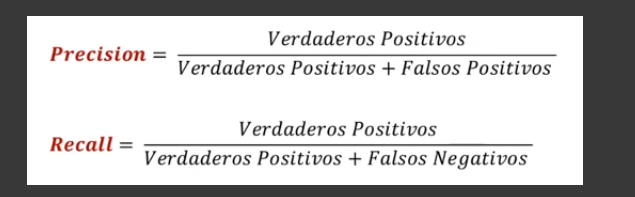

### **RandomForestClassifier**


In [83]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
hyperparameters_tuning = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(hyperparameters_tuning)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


#### **RandomForest Classifier - Corpus del contexto politico colombiano**

In [84]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=rng)

# Definition of the random search
random_search_cp = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=rng)

# Fit the random search model
random_search_cp.fit(features_train_cp, labels_train_cp)
print("Mejores hiperparametros:",random_search_cp.best_params_)
print("Accuracy hiperparametros:",random_search_cp.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparametros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}
Accuracy hiperparametros: 0.8678500986193294
CPU times: user 24.2 s, sys: 123 ms, total: 24.3 s
Wall time: 24.7 s


In [85]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf_cp = RandomForestClassifier(n_estimators=200, min_samples_split=2,min_samples_leaf=2, max_features='sqrt', max_depth=100, bootstrap=False)
clf_cp.fit(features_train_cp, labels_train_cp)
clf_predict_cp = clf_cp.predict(features_test_cp)

Text(39.49999999999999, 0.5, 'Predicted')

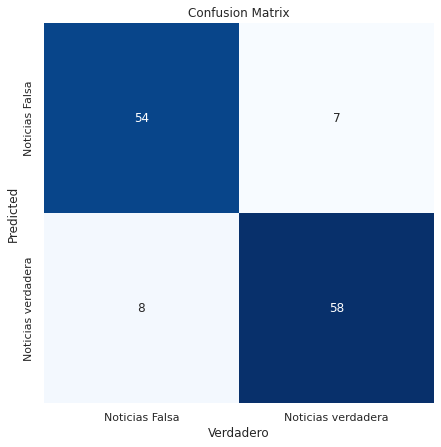

In [86]:
# Matrix de confunsión Corpus del contexto politico colombiano
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, clf_predict_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [87]:
accuracy_randomforest_cp=accuracy_score(labels_test_cp, clf_predict_cp)
print("Accuracy Corpus propio",accuracy_randomforest_cp)

Accuracy Corpus propio 0.8818897637795275


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


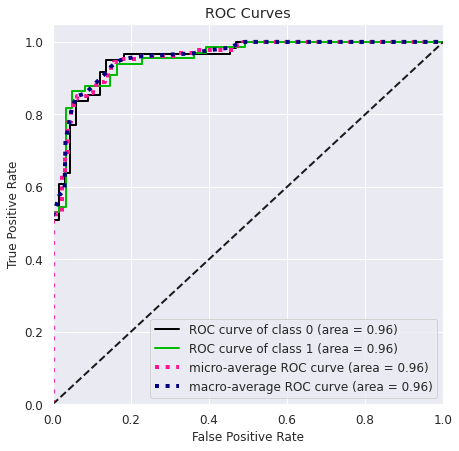

In [88]:
clf_predict_proba_cp = clf_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, clf_predict_proba_cp)
plt.show()

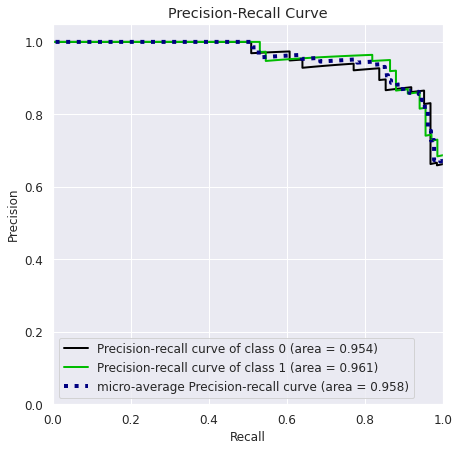

In [89]:
skplt.metrics.plot_precision_recall(labels_test_cp,clf_predict_proba_cp)

#### **RandomForest Classifier - Corpus Combinado**

In [90]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=rng)
# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=rng)

# Fit the random search model
random_search.fit(features_train, labels_train)
print("Mejores hiperparametros:",random_search.best_params_)
print("Accuracy hiperparametros:",random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparametros: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}
Accuracy hiperparametros: 0.680141139128358
CPU times: user 1min 29s, sys: 297 ms, total: 1min 30s
Wall time: 1min 31s


In [91]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf = RandomForestClassifier(n_estimators=600, min_samples_split=5,min_samples_leaf=1, max_features='auto', max_depth=100, bootstrap=False)
clf.fit(features_train, labels_train)
clf_predict = clf.predict(features_test)

Text(39.49999999999999, 0.5, 'Predicted')

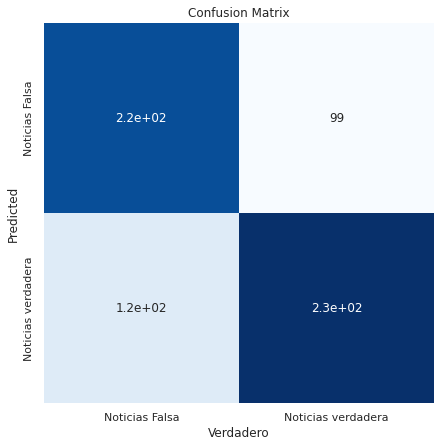

In [92]:
# Matrix de confunsión 1000 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, clf_predict)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [93]:
dataframe_graf

Noticias Falsa  Noticias verdadera
Noticias Falsa                 216                  99
Noticias verdadera             116                 231

In [94]:
accuracy_randomforest=accuracy_score(labels_test, clf_predict)
print(accuracy_randomforest)

0.675226586102719


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


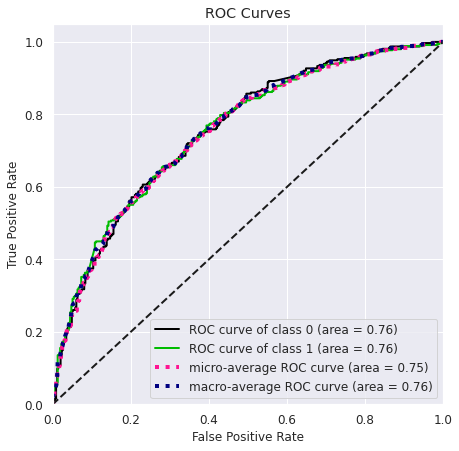

In [95]:
clf_predict_proba = clf.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, clf_predict_proba)
plt.show()

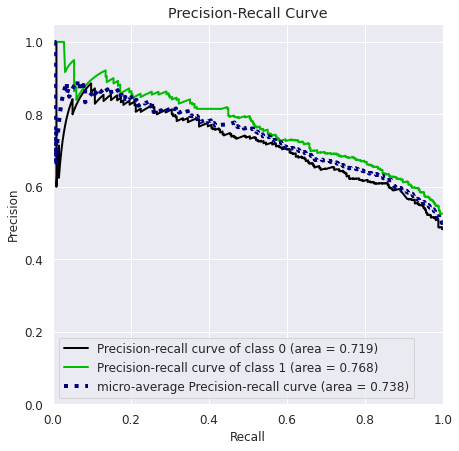

In [96]:
skplt.metrics.plot_precision_recall(labels_test,clf_predict_proba)

## **Naive Bayes**

### **Naive Bayes Corpus del contexto politico colombiano**

In [97]:
%%time
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb_cp,predictions_nb_cp,accuracy_nb_cp=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 69.4 ms, sys: 18 µs, total: 69.4 ms
Wall time: 71.3 ms


In [98]:
MultinomialNB().get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [99]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb_cp)
print("Mejores hiperparametros NB:",best_model_nb_cp.best_params_)

Naive Bayes Accuracy Score ->  0.8740157480314961
Mejores hiperparametros NB: {'fit_prior': True, 'alpha': 1}


Text(39.49999999999999, 0.5, 'Predicted')

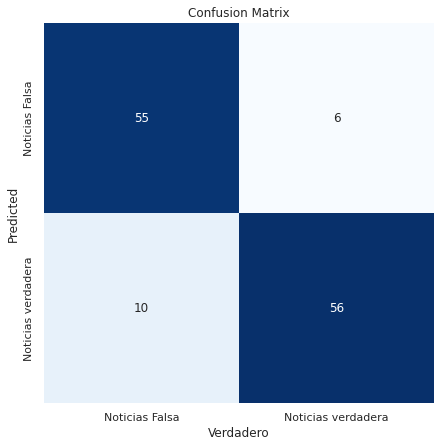

In [100]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_nb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


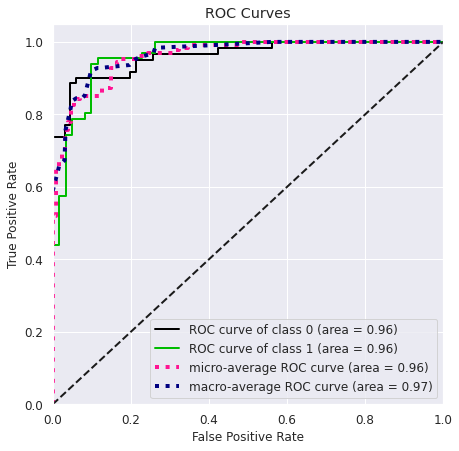

In [101]:
predict_nb_cp=best_model_nb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_nb_cp)
plt.show()

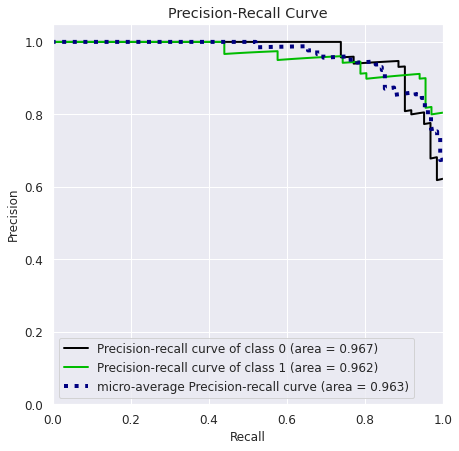

In [102]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_nb_cp)

### **Naive Bayes Corpus Combinado**

In [103]:
%%time
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb,predictions_nb,accuracy_nb=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 84.7 ms, sys: 995 µs, total: 85.7 ms
Wall time: 85.2 ms


In [104]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb)
print("Mejores hiperparametros NB:",best_model_nb.best_params_)

Naive Bayes Accuracy Score ->  0.6253776435045317
Mejores hiperparametros NB: {'fit_prior': True, 'alpha': 1e-05}


Text(39.49999999999999, 0.5, 'Predicted')

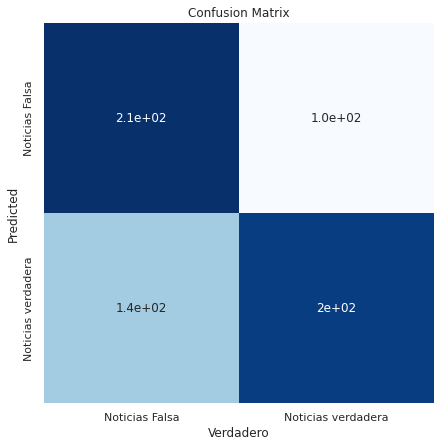

In [105]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_nb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [106]:
dataframe_graf

Noticias Falsa  Noticias verdadera
Noticias Falsa                 210                 105
Noticias verdadera             143                 204

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


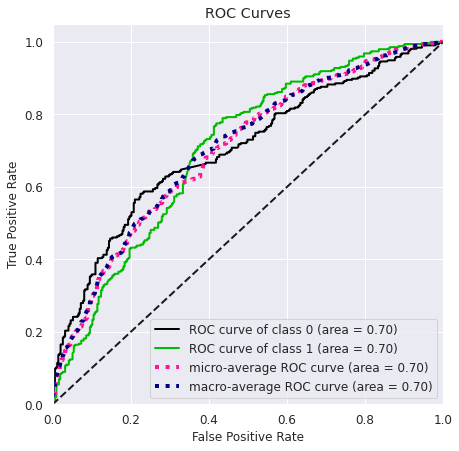

In [107]:
predict_nb=best_model_nb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_nb)
plt.show()

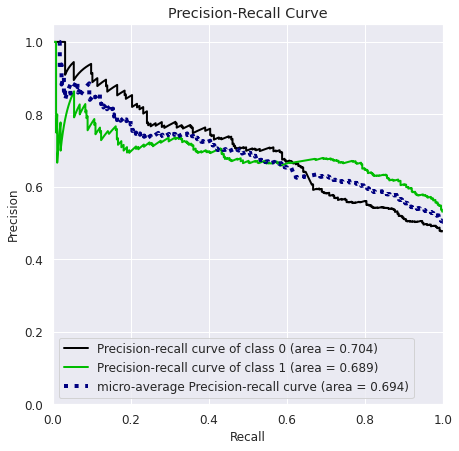

In [108]:
skplt.metrics.plot_precision_recall(labels_test,predict_nb)

## **SVC**

### **SVC Corpus del contexto politico colombiano**

In [109]:
%%time
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc_cp,predictions_svc_cp,accuracy_svc_cp=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 1.98 s, sys: 2.91 ms, total: 1.99 s
Wall time: 1.98 s


In [110]:
print("SVM Accuracy Score -> ",accuracy_svc_cp)
print("Mejores hiperparametros SVM:",best_model_svc_cp.best_params_)

SVM Accuracy Score ->  0.889763779527559
Mejores hiperparametros SVM: {'kernel': 'rbf', 'gamma': 1, 'C': 100}


Text(39.49999999999999, 0.5, 'Predicted')

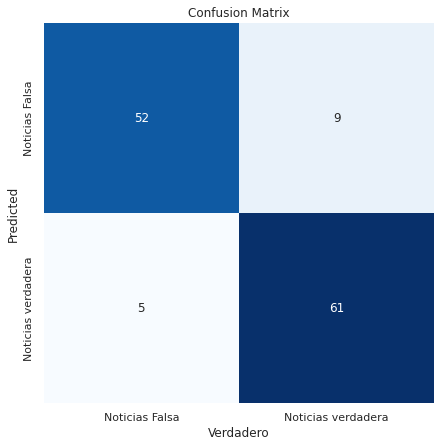

In [111]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_svc_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


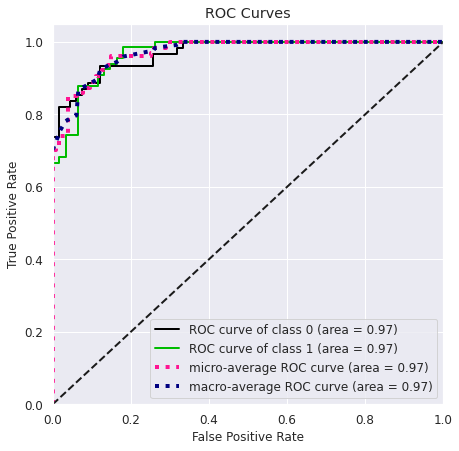

In [112]:
predict_svc_cp=best_model_svc_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_svc_cp)
plt.show()

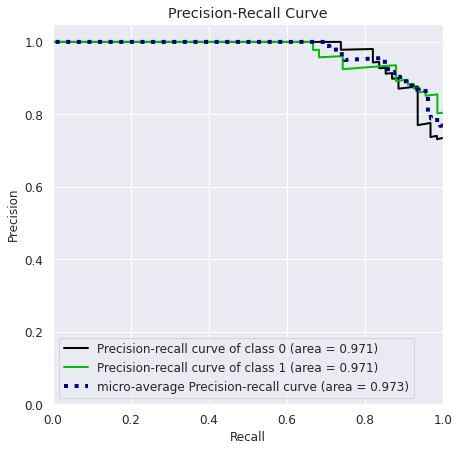

In [113]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_svc_cp)

### **SVC Corpus Combinado**

In [ ]:
%%time
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc,predictions_svc,accuracy_svc=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)                                       

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
print("SVM Accuracy Score -> ",accuracy_svc)
print("Mejores hiperparametros SVM:",best_model_svc.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_svc)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
predict_svc=best_model_svc.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_svc)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,predict_svc)

## **Logistic Regression**

### **Logistic Regression Corpus del contexto politico colombiano**

In [ ]:
%%time
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
best_model_logistic_cp,predictions_logistic_cp,accuracy_logistic_cp=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic_cp)
print("Mejores hiperparametros LR:",best_model_logistic_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_logistic_cp)
# crear dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# crear headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
y_pred_proba_cp= best_model_logistic_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **Logistic Regression Corpus Combinado**

In [ ]:
%%time
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
best_model_logistic,predictions_logistic,accuracy_logistic=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic)
print("Mejores hiperparametros LR:",best_model_logistic.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_logistic)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
y_pred_proba= best_model_logistic.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **XGBoost**

### **XGBoost Corpus del contexto politico colombiano**

In [ ]:
%%time
# learning rate: Que tán rápido aprende el modelo y para controlar el overfitting.
# colsample_bytree: Porcentaje de caracteristicas utilizadas por árbol.
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb_cp,predictions_xgb_cp,accuracy_xgb_cp=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("XGBoost Accuracy Score: ",accuracy_xgb_cp)
print("Mejores hiperparametros XG:",best_model_xgb_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_xgb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
y_pred_proba_cp= best_model_xgb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **XGBoost Corpus Combinado**

In [ ]:
%%time
# learning rate: Que tán rápido aprende el modelo y para controlar el overfitting.
# colsample_bytree: Porcentaje de caracteristicas utilizadas por árbol.
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb,predictions_xgb,accuracy_xgb=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("XGBoost Accuracy Score: ",accuracy_xgb)
print("Mejores hiperparametros XG:",best_model_xgb.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_xgb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
y_pred_proba= best_model_xgb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **Redes Neuronales**

### **Red Neuronal Corpus del contexto politico colombiano**

In [ ]:
# crear modelo
#features_train_cp.shape[1] representa el numero de columnas de los datos de entrenamiento.
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(12, input_dim=features_train_cp.shape[1], activation='relu'))
model.add(Dense(128 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(8 , activation='relu' ))
model.add(Dense(1 , activation='sigmoid' ))

In [ ]:
# Compile model
# https://keras.io/api/optimizers/adam/
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

In [ ]:
print(features_train_cp.shape)
print(features_test_cp.shape)
print(type(features_train_cp))
print(type(labels_test_cp))
print((features_train_cp.shape[1]))

In [ ]:
# Separación datos de entreanmiento y datos de validación
dataxTrain=features_train_cp[100:,:]
datayTrain=labels_train_cp[100:]

DataxVal=features_train_cp[:100,:]
DatayVal=labels_train_cp[:100]

print(dataxTrain.shape)
print(datayTrain.shape)
print(DataxVal.shape)
print(DatayVal.shape)

In [ ]:
X_train_nn_cp=dataxTrain.toarray()
y_train_nn_cp=datayTrain.to_numpy()
X_val_nn_cp=DataxVal.toarray()
y_val_nn_cp=DatayVal.to_numpy()  

In [ ]:
print(X_train_nn_cp.shape)
print(y_train_nn_cp.shape)
print(X_val_nn_cp.shape)
print(y_val_nn_cp.shape)

In [ ]:
%%time
# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
entrenamiento=model.fit(x= X_train_nn_cp, 
                        y=y_train_nn_cp,
                        validation_data=(X_val_nn_cp,
                                         y_val_nn_cp),
                        batch_size=32,
                        callbacks=[callback],
                        epochs=200,
                        verbose=1)

In [ ]:
#X_train_cp, X_test_cp, y_train_cp, y_test_cp 
loss, accuracy_nncp = model.evaluate(features_test_cp.toarray(), labels_test_cp.to_numpy())

In [ ]:
prediccion=model.predict(features_test_cp.toarray())

In [ ]:
# Para sacar la matriz de confusión:
y_predict=(prediccion>0.5)
confusion_matrix(labels_test_cp,y_predict)

In [ ]:
print(labels_test_cp.shape)
print(labels_test_cp.shape)

In [ ]:
## grafica de la evolución de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'], label="Val Error")
  plt.legend()
  plt.show()

plot_history(entrenamiento)

In [ ]:
## grafica de la evolución de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label="Val Error")
  plt.legend()
  plt.show()

plot_history(entrenamiento)

### **Red Neuronal Corpus Combinado**

In [ ]:
# create model
#features_train_cp.shape[1] representa el numero de columnas de los datos de entrenamiento.
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(12, input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(128 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(8 , activation='relu' ))
model.add(Dense(1 , activation='sigmoid' ))

In [ ]:
# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

In [ ]:
DataxVal=features_train[:529,:]
DatayVal=labels_train[:529]

dataxTrain=features_train[529:,:]
datayTrain=labels_train[529:]

print(dataxTrain.shape)
print(datayTrain.shape)
print(DataxVal.shape)
print(DatayVal.shape)

In [ ]:
X_train_nn_cp=dataxTrain.toarray()
y_train_nn_cp=datayTrain.to_numpy()
X_val_nn_cp=DataxVal.toarray()
y_val_nn_cp=DatayVal.to_numpy()  

In [ ]:
print(X_train_nn_cp.shape)
print(y_train_nn_cp.shape)
print(X_val_nn_cp.shape)
print(y_val_nn_cp.shape)

In [ ]:
%%time
# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
entrenamiento=model.fit(x= X_train_nn_cp, 
                        y=y_train_nn_cp,
                        validation_data=(X_val_nn_cp,
                                         y_val_nn_cp),
                        batch_size=32,
                        callbacks=[callback],
                        epochs=200,
                        verbose=1)

In [ ]:
loss, accuracy_cc = model.evaluate(features_test.toarray(), labels_test.to_numpy())

In [ ]:
prediccion=model.predict(features_test.toarray())

In [ ]:
# Para sacar la matriz de confusión:
y_predict=(prediccion>0.5)
confusion_matrix(labels_test,y_predict)

In [ ]:
print(features_test.shape)
print(labels_test.shape)

In [ ]:
## grafica de la evolución de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'], label="Val Error")
  plt.legend()
  plt.show()

plot_history(entrenamiento)

In [ ]:
## grafica de la evolución de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label="Val Error")
  plt.legend()
  plt.show()

plot_history(entrenamiento)

# **BERT**

###BERT Con Corpus del contexto politico colombiano realizando la limpieza del texto previamente



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT: Con el fin de poder tener los datos en una forma que pueda 
# ser interpretada por BERT, se realiza una separación de las noticias.
noticias_falsas=df_base_cp[df_base_cp['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base_cp[df_base_cp['Categoria']=='Noticia Real']

In [ ]:
# con .sample(frac=1): devuelve todas las filas en orden aleario, se realiza el suffle de los datos para 
#los dos tipos de noticias; la verdaderas y las falsas.
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
# visualizar las noticias verdaderas.
new_dataframe_suffle_true

In [ ]:
# visualizar las noticias falsas.
new_dataframe_suffle_false

In [ ]:
# verificamos las dimensiones.
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

In [ ]:
# separación de los datos en entrenamiento y pruebas.
test_true=new_dataframe_suffle_true.iloc[:60,:]
test_false=new_dataframe_suffle_false.iloc[:60,:]
training_true=new_dataframe_suffle_true.iloc[60:,:]
training_false=new_dataframe_suffle_false.iloc[60:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

In [ ]:
test_true

In [ ]:
# se realiza un "reset" al indice
test_true=test_true.reset_index(drop=True)
test_false=test_false.reset_index(drop=True)

training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
training_false.Texto.iloc[200]

In [ ]:
# extracción de la longitud de cada tipo de noticias .
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Processed_Text'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
## se leen las noticias utilizando las utilidades de keras

AUTOTUNE = tf.data.AUTOTUNE # configuración para un mejor rendimiento
batch_size = 32 # configuración del tamaño del batch.
seed = 42

# tf.keras.utils.text_dataset_from_directory. Genera un tf.data.Dataset a partir de archivos de texto en un directorio.
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
# Calcula la pérdida de entropía cruzada entre etiquetas verdaderas y etiquetas de la predicción.
# from_logits: para  tener el resultado en cálculo de probabilidades.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#Esta métrica crea dos variables locales, total y recuento, que se utilizan para calcular la frecuencia
#con la que y_pred coincide con y_true. Esta frecuencia finalmente se devuelve como precisión binaria:
# una operación idempotente que simplemente divide el total por el conteo.
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 5 # parametro de las epocas
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy() # retorna la cardinalidad del dataset de entrada a la función: 13
num_train_steps = steps_per_epoch * epochs # multiplicación entre los step por época y las épocas
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5 # parámetro learning rate
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# se crea la ruta para guardar el modelo
dataset_name = 'noticias'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

In [ ]:
# se gurada el modelo entrenado en la ruta establecida.
classifier_model.save(saved_model_path, include_optimizer=False)

###BERT Con corpus combinado realizando la limpieza previa de los datos



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_merge[df_merge['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_merge[df_merge['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true

In [ ]:
new_dataframe_suffle_false

In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

In [ ]:
test_true=new_dataframe_suffle_true.iloc[:331,:]
test_false=new_dataframe_suffle_false.iloc[:331,:]
training_true=new_dataframe_suffle_true.iloc[331:,:]
training_false=new_dataframe_suffle_false.iloc[331:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

In [ ]:
test_true

In [ ]:
training_true.Processed_Text.iloc[256]

In [ ]:
training_false.Processed_Text.iloc[200]

In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())

In [ ]:
# para borra los directorios creados en la sección anterior.
import shutil
os.chdir('/content')
shutil.rmtree('news')

In [ ]:
training_false.shape

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Processed_Text'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### BERT con Corpus del contexto politico colombiano sin preprocesar



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base_cp[df_base_cp['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base_cp[df_base_cp['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true['Texto'].iloc[100]

In [ ]:
new_dataframe_suffle_false

In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

In [ ]:
test_true=new_dataframe_suffle_true.iloc[:60,:]
test_false=new_dataframe_suffle_false.iloc[:60,:]
training_true=new_dataframe_suffle_true.iloc[60:,:]
training_false=new_dataframe_suffle_false.iloc[60:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

In [ ]:
test_true

In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
print(len(training_false))
print(len(training_true))
print(len(test_false))
print(len(test_true))

In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

In [ ]:
# para borra los directorios creados anteriormente.
import shutil
os.chdir('/content')
shutil.rmtree('news')

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Texto'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Texto'][i])
os.chdir('/content')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

label_class_names = test_ds.class_names

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
prediccion=classifier_model.predict(test_ds)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'noticiasColombianas'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
classifier_model.save(saved_model_path, include_optimizer=False)


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

### BERT con corpus combinado sin preprocesar



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base[df_base['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base[df_base['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true['Texto'].iloc[360]

In [ ]:
new_dataframe_suffle_false

In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

In [ ]:
test_true=new_dataframe_suffle_true.iloc[:331,:]
test_false=new_dataframe_suffle_false.iloc[:331,:]
training_true=new_dataframe_suffle_true.iloc[331:,:]
training_false=new_dataframe_suffle_false.iloc[331:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

In [ ]:
test_true

In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
print(len(training_false))
print(len(training_true))
print(len(test_false))
print(len(test_true))

In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

In [ ]:
# para borra los directorios
import shutil
os.chdir('/content')
shutil.rmtree('news')

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Texto'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Texto'][i])
os.chdir('/content')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

label_class_names = test_ds.class_names

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


In [ ]:
clasif_BERT=classifier_model.predict(test_ds)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'noticias'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

#**Evaluación**

###**Evaluación de Modelos con Corpus del contexto politico colombiano**

In [ ]:
listas_cp=[["Random Forest",accuracy_randomforest_cp],["Naive Bayes",accuracy_nb_cp],["SVC",accuracy_svc_cp],
           ["Logistic Regression",accuracy_logistic_cp],["XGBoost",accuracy_xgb_cp],
           ["Neural Network",accuracy_nncp]]
df_listas_cp=pd.DataFrame(listas_cp,columns=["Modelos","Métrica - Accuracy"])
df_listas_cp
df_listas_cp.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#FFFFFF'})

###**Evaluación de Modelos con el Corpus combinado**

In [ ]:
listas=[["Random Forest",accuracy_randomforest],["Naive Bayes",accuracy_nb],
           ["SVC",accuracy_svc],["Logistic Regression",accuracy_logistic],["XGBoost",accuracy_xgb],
         ["Neural Network",accuracy_cc]]
df_listas=pd.DataFrame(listas,columns=["Modelos","Métrica - Accuracy"])
df_listas
df_listas.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#FFFFFF'})

# **Pruebas**

In [ ]:
df_news_test=classification_news_twitter("@RevistaSemana",10, clf_cp)

In [ ]:
df_news_test

# Webscrapping

In [ ]:
print(webscrapping("https://www.semana.com/nacion/articulo/alias-otoniel-o-la-sonrisa-del-mal-asi-se-le-vio-al-partir-de-colombia-hacia-ee-uu/202251/?utm_term=Autofeed&utm_campaign=Echobox&utm_medium=Social&utm_source=Twitter#Echobox=1651710236"))


## Pruebas de clasificación de Tweets con BERT entrenado con noticias del contexto político colombiano.



In [ ]:
classification_news_twitter_BERT("@RevistaSemana",10)

# **Modelos para producción**

### Se guardan los modelos para su paso a producción

In [ ]:
create_model_production("RF",clf_cp)
create_model_production("NB",best_model_nb)
create_model_production("SVC",best_model_svc)
create_model_production("LR",best_model_logistic)
create_model_production("Xgboost",best_model_xgb)
create_model_production("vectorizer",tfidf)
create_model_production("vectorizer_cp",tfidf_cp)